In [1]:
from tda import auth, client
import json
import pandas as pd
from datetime import timezone
import datetime
import time
import numpy as np

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, NumeralTickFormatter
from bokeh.models import Range1d, HoverTool
from bokeh.models import LinearAxis, WheelZoomTool, DataRange1d
from math import pi
from bokeh.layouts import gridplot
from bokeh.palettes import d3

In [2]:
def get_date(d):
    return datetime.datetime.fromtimestamp(d/1000)

In [3]:
df = pd.read_csv('../data/ninja-trade/joined.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

,datetime,open,high,low,close,volume
0,2020-01-01 23:01:00,8773.00,8778.50,8769.50,8773.75,272
1,2020-01-01 23:02:00,8773.50,8773.75,8770.00,8770.00,118
2,2020-01-01 23:03:00,8770.00,8772.00,8769.25,8771.00,121
3,2020-01-01 23:04:00,8771.25,8773.75,8771.25,8773.00,73
4,2020-01-01 23:05:00,8772.75,8773.00,8771.25,8771.25,46


In [4]:
def fisher_transform(close, period=9):
    # Calculate the midpoint price
    mp = (close + pd.Series.rolling(close, window=period).min() + pd.Series.rolling(close, window=period).max()) / 3
    
    # Calculate the difference between the midpoint price and the close price
    diff = close - mp
    
    # Calculate the maximum and minimum values over the period
    max_diff = pd.Series.rolling(diff.abs(), window=period).max()
    min_diff = pd.Series.rolling(diff.abs(), window=period).min()
    
    # Calculate the relative strength
    rs = (diff - min_diff) / (max_diff - min_diff)
    
    # Calculate the Fisher Transform
    fish = 0.5 * np.log((1 + rs) / (1 - rs))
    
    return fish

In [5]:
nasdaq_data = df['close'].values

In [6]:
def fix_periods(df, col):
    df[col] = df[col].fillna(0)
    fisher_min = df[df[col]>-np.inf][col].min()
    fisher_max = df[df[col]<np.inf][col].max()
    df.loc[df[col] == np.inf,col]=fisher_max
    df.loc[df[col] == -np.inf,col]=fisher_min


In [7]:
periods = [9,20, 50]
for period in periods:
    col = f'fisher{period}'
    df[col] = fisher_transform(df['close'], period=period)
    fix_periods(df, col)
    df[col + 'ma2']=df[col].rolling(window=2).mean()

C:\Users\amatu\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\amatu\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\amatu\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\amatu\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\amatu\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, meth

In [8]:
df.head()

,datetime,open,high,low,close,volume,fisher9,fisher9ma2,fisher20,fisher20ma2,fisher50,fisher50ma2
0,2020-01-01 23:01:00,8773.00,8778.50,8769.50,8773.75,272,0.0,NaN,0.0,NaN,0.0,NaN
1,2020-01-01 23:02:00,8773.50,8773.75,8770.00,8770.00,118,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-01 23:03:00,8770.00,8772.00,8769.25,8771.00,121,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-01 23:04:00,8771.25,8773.75,8771.25,8773.00,73,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-01 23:05:00,8772.75,8773.00,8771.25,8771.25,46,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

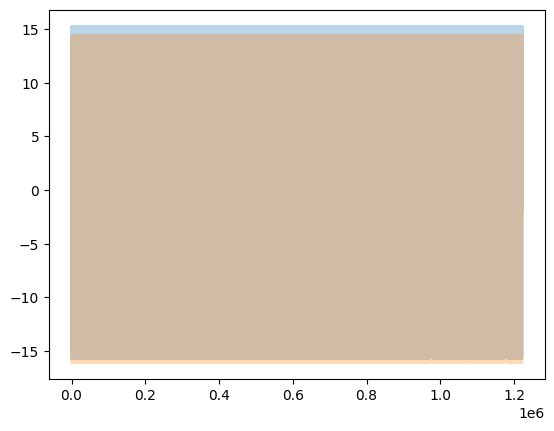

In [9]:
# (((df['close'].max()-df['close'])/df['close'].max())*50).plot(alpha=0.3)
df['fisher9'].plot(alpha=0.3)
df['fisher20'].plot(alpha=0.3)

In [13]:
df = df.iloc[:100000]

In [14]:
df

,datetime,open,high,low,close,volume,fisher9,fisher9ma2,fisher20,fisher20ma2,fisher50,fisher50ma2
0,2020-01-01 23:01:00,8773.00,8778.50,8769.50,8773.75,272,0.000000,NaN,0.0,NaN,0.000000,NaN
1,2020-01-01 23:02:00,8773.50,8773.75,8770.00,8770.00,118,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,2020-01-01 23:03:00,8770.00,8772.00,8769.25,8771.00,121,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,2020-01-01 23:04:00,8771.25,8773.75,8771.25,8773.00,73,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,2020-01-01 23:05:00,8772.75,8773.00,8771.25,8771.25,46,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2020-04-15 12:20:00,8572.25,8572.25,8568.25,8571.25,232,-0.137853,-0.068926,0.0,0.0,-1.160039,-1.088250
99996,2020-04-15 12:21:00,8570.75,8571.50,8564.00,8566.50,298,-0.788457,-0.463155,0.0,0.0,0.000000,-0.580020
99997,2020-04-15 12:22:00,8566.25,8570.50,8565.25,8567.50,216,-0.281154,-0.534806,0.0,0.0,-2.271647,-1.135824
99998,2020-04-15 12:23:00,8567.00,8568.00,8565.25,8567.00,252,-0.387532,-0.334343,0.0,0.0,-15.243896,-8.757771


In [15]:
df['fisher9'].describe()

count    100000.000000
mean          1.130545
std           4.943560
min         -15.717993
25%          -0.255413
50%           0.000000
75%           0.530738
max          15.274782
Name: fisher9, dtype: float64

In [16]:
source = ColumnDataSource(data=dict(
    date=df['datetime'],
    idx=df.index,
    open=df["open"],
    high=df["high"],
    low=df["low"],
    close=df["close"]
))
fisher_source = ColumnDataSource(data=dict(
    # date=df['datetime'],
    idxs=[df.index for period in periods],
    fishers=[df[f'fisher{period}'] for period in periods],
    periods=[f'{period}' for period in periods],
    colors = [d3['Category10'][len(periods)][i] for i in range(len(periods))]
    # **{f'fisher{period}':df[f'fisher{period}'] for period in periods}
))
# Create a new figure
price_p = figure(#x_axis_type="datetime", 
            width=1500, height=450, 
            title="E-Mini Nasdaq 100",
            # x_range=DataRange1d(),
            background_fill_color="#3b3b3b",
            border_fill_color="white")
price_p.xaxis.major_label_orientation = pi/4
price_p.grid.grid_line_alpha=0.3

inc = df['close'] > df['open'] # green candels
dec = df['open'] > df['close'] # red candels
w = 1

# Render the candlestick chart
price_p.segment(x0='idx', y0='high', x1='idx', y1='low', color="white", source=source)
price_p.vbar(x=df.index[inc], top=df['open'][inc], bottom=df['close'][inc], width=w, fill_color="#76f522", line_color="white")
price_p.vbar(x=df.index[dec], top=df['open'][dec], bottom=df['close'][dec], width=w, fill_color="#F2583E", line_color="white")

# Format the y-axis tick labels
price_p.yaxis[0].formatter = NumeralTickFormatter(format="$0,000.00")
price_p.yaxis[0].axis_line_color = "white"
price_p.yaxis[0].major_tick_line_color = "white"
price_p.yaxis[0].minor_tick_line_color = "white"
# price_p.toolbar.active_scroll = p.select_one(WheelZoomTool)

# map dataframe indices to date strings and use as label overrides
price_p.xaxis.major_label_overrides = {
    i: date.strftime('%d') for i, date in enumerate(df["datetime"])
}
price_p.xaxis.bounds = (0, df['datetime'].values[-1])


# fisher rande excluding -inf and +inf
# fisher_min = df[df['fisher9']>df['fisher9'].min()]['fisher9'].min()
# fisher_max = df[df['fisher9']<df['fisher9'].max()]['fisher9'].max()

# Create a new figure for the Fisher Transform Indicator
fisher_p = figure(#x_axis_type="datetime",
                 width=1500, height=300, 
                 title=f"Fisher Transform ({period})",
                 x_range=price_p.x_range,
                 background_fill_color="#3b3b3b",
                 border_fill_color="white")

# Add a second y-axis for the Fisher Transform values
# p.extra_y_ranges = {"fisher": Range1d(start=fisher_min*2, end=fisher_max*2)}
# p.add_layout(LinearAxis(y_range_name="fisher", axis_label="Fisher Transform"), 'right')

# Render the Fisher Transform Indicator on the second y-axis
# p.plot(x='date', y='fisher', color="#FF9F1C", line_width=2, y_range_name="fisher", source=source)
# for i, period in enumerate(periods):
#    fisher_p.multi_line(x='idxs', y=f'fisher{period}', color=, line_width=2, source=fisher_source)
fisher_p.multi_line(xs='idxs', ys=f'fishers', color='colors', line_width=2, source=fisher_source)
# Add a second y-axis for the Fisher Transform values
# fisher_p.add_layout(LinearAxis(y_range_name="fisher", axis_label="Fisher Transform", axis_line_color="white", major_tick_line_color="white", minor_tick_line_color="white"), 'left')
fisher_p.add_tools(WheelZoomTool(dimensions="width"))

# hover_tool = HoverTool(tooltips=[("Fisher Transform", f"@fisher{period}") for i, period in enumerate(periods)], mode="vline")
hover_tool = HoverTool(show_arrow=False, line_policy='next',tooltips=[('', "$swatch:colors"),('period','@periods')])

fisher_p.add_tools(hover_tool)
# map dataframe indices to date strings and use as label overrides
fisher_p.xaxis.major_label_overrides = {
    i: date.strftime('%d') for i, date in enumerate(df["datetime"])
}
# fisher_p.xaxis.bounds = (0, df['datetime'].values[-1])


# Set the gridplot
grid = gridplot([[price_p], [fisher_p]])

# Show the plot
output_file("./chart.html")
show(grid)